# Classifying Shapes

In this notebook I build a convolutional neural network using PyTorch and train it to classify images of circles, squares and triangles. Whilst writing this I am learning to build machine learning models on Microsoft Azure and this notebook is based on examples from that course.

In [1]:
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.9.0+cpu


## Data Exploration

With the necessary packages imported we can explore the data by examining the classes and plotting some examples.

3 classes:
['circle', 'square', 'triangle']


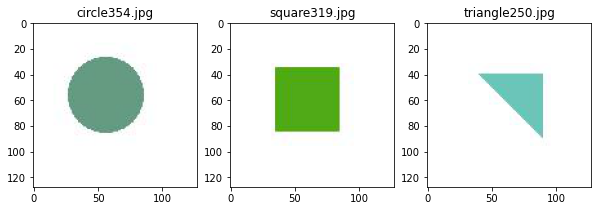

In [7]:
#Use the names of the directories as the class names
data_path = 'data/shapes'
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

#Plot an example from each class
fig = plt.figure(figsize=(10, 10))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    image_file_name = os.listdir(os.path.join(data_path,sub_dir))[0]
    image_path = os.path.join(data_path, sub_dir, image_file_name)
    img = mpimg.imread(image_path)
    a=fig.add_subplot(1, len(classes),i)
    imgplot = plt.imshow(img)
    a.set_title(image_file_name)
plt.show()

## Preparing the Data

Now we will define a function that makes use of PyTorch's loading functions. The images need to be transformed into tensors to be used by PyTorch. We can also use this as an opportunity for feature scaling, and will scale the pixel values to have a mean of 0.5 and standard deviation also of 0.5.

In [8]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        #transform the images to tensors
        transforms.ToTensor(),
        #Normalise the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    #Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    #Split into training (70%) and test (30%) datasets
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    #define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    #now the same for the test data
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


#Call the loading functions
train_loader, test_loader = load_dataset(data_path)
print('Data loading functions ready')

Data loading functions ready


## Define the CNN

Now we will define the neural network model as a class derived from PyTorch's nn.Module class. In the CNN model, the \textbf{kernal_size} parameter determines the size of the convolutional kernel or filter, \textbf{stride} determines the step size or the number of pixels the kernel moves at each step during the convolution operation and \textbf{padding} is used to preserve the spatial dimensions of the input after convolution.

In [9]:
class Neural_Net(nn.Module):
    #construct the network
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        #As the images are RGB, we need 3 input channels. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        #We'll apply max pooling to pick out the most prominent features, using a kernel size of 2.
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        #The next layer will take 12 input channels and generate 12 outputs, using a kernal size of 3.
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        #We'll add a third layer that takes 12 inputs and this time generate 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        #The drop layer deletes 20% of the features which helps prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)

## Train the model